- [빅쿼리 공식문서: Python 라이브러리](https://cloud.google.com/bigquery/docs/python-libraries?hl=ko#features_not_supported_by_pandas-gbq)

In [39]:
# %pip install google-cloud-bigquery

### 라이브러리 import

In [40]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./config/*.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials=credentials, project=credentials.project_id)


import warnings

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

In [41]:
# sql = f"""
# WITH session_list AS (
#   -- 전체 세션 리스트 
#   SELECT
#     EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS event_date,
#     TIMESTAMP_MICROS(event_timestamp) AS event_datetime,
#     user_pseudo_id,
#     user_id,
#     event_name, 
#     MAX(IF(params.key='firebase_screen', params.value.string_value, NULL)) AS `firebase_screen`, 
#     MAX(IF(params.key='session_id', params.value.string_value, NULL)) AS `session_id`, 
#     -- platform,
#   FROM advanced.app_logs
#   CROSS JOIN UNNEST(event_params) AS params
#   GROUP BY ALL
# )
# , order_logs AS (
#   -- 주문 로그
#   SELECT *
#   FROM session_list
#   WHERE event_name = 'click_payment'
# )
# , logs_never_ordered_before AS (
#   -- 주문 내역 없는 유저의 로그
#   SELECT
#     *
#   FROM session_list
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     -- 주문 내역 있는 유저 리스트
#     SELECT DISTINCT user_pseudo_id
#     FROM order_logs
#   )
# )
# , logs_ordered_before AS (
#   -- 주문 내역 있는 유저의 로그
#   SELECT
#     *
#   FROM session_list
#   WHERE 1=1
#   AND user_pseudo_id IN (
#     -- 주문 내역 있는 유저 리스트
#     SELECT DISTINCT user_pseudo_id
#     FROM order_logs
#   )
# )

# -- 3. 주문 내역 있는 유저: cohort weekly retention
# -- 주문 내역 있는 유저 중에서도 유입주차별로 나눠서 봤을 때 특히나 지속적으로 사용하는 그룹이 있을까?
# -- 만약 그렇다면 그 유입 주차가 연휴 주차인가?

# -- 3) 사용자별 첫방문일, 방문일, 방문간격(주차)
# , week_diff_per_user AS (
#   SELECT
#     *,
#     DATE_DIFF(event_week, first_week, WEEK) AS week_diff
#   FROM (
#     -- 2) 사용자별 첫방문일, 방문일 리스트 추출
#     SELECT DISTINCT
#       user_pseudo_id,
#       DATE_TRUNC(MIN(event_date) OVER (PARTITION BY user_pseudo_id), WEEK(MONDAY)) AS first_week,
#       DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week
#     FROM logs_ordered_before
#     -- ORDER BY user_pseudo_id, event_week
#   )
#   -- ORDER BY user_pseudo_id, event_week
# )
# , week_retain AS (
#   -- 코호트별 주차별 사용자 수 카운팅
#   SELECT
#     first_week,
#     week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS retain_users
#   FROM week_diff_per_user
#   GROUP BY first_week, week_diff
#   -- ORDER BY first_week, week_diff
# )
# , week_retain_first AS (
#   -- 코호트별 0주차 사용자 수 추출
#   SELECT first_week, retain_users
#   FROM week_retain
#   WHERE week_diff = 0
# ) 


# -- 주차별 코호트 리텐션 계산
# SELECT
#   f.first_week,
#   w.week_diff,
#   w.retain_users,
#   f.retain_users AS first_users,
#   ROUND(SAFE_DIVIDE(w.retain_users,f.retain_users)*100,3) AS retention_rate
# FROM week_retain w
# CROSS JOIN week_retain_first f
# WHERE f.first_week = w.first_week
# AND f.first_week != '2022-07-25' 
# ORDER BY w.first_week, week_diff
# """

# query_job = client.query(sql)
# df = query_job.to_dataframe()
# df.head()

In [42]:
# %pip install db-dtypes

In [43]:
# df.info()

In [44]:
# import pandas as pd

# # first_week 컬럼을 datetime 자료형으로 변경
# df['first_week'] = df['first_week'].astype('str')

# df['first_week'] = pd.to_datetime(df['first_week'])
# df['first_week'] = df['first_week'].dt.date

# df.info()

In [45]:
# df.head()

In [46]:
# # week_diff를 float로 변경
# df['week_diff'] = df['week_diff'].astype(float)

In [47]:
# df['first_week'].unique()

In [48]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly as ply
# import plotly.graph_objects as go

# # 주문 내역 있는 유저들의 주차별 코호트 리텐션 그래프
# # 각 코호트마다 그래프를 그릴 것이다.


# temp = df['first_week'].unique()[1]
# df_target = df.loc[df['first_week'] == temp]

# sns.lineplot(data=df_target, x='week_diff', y='retention_rate')

In [49]:
# import plotly.express as ex

# fig = ex.line(data_frame=df, x='week_diff', y='retention_rate', color='first_week')

# fig.show()

### 주문 퍼널
#### 일별 주문 퍼널 전환율 추이

In [50]:
sql = f"""
/* 일별 주문 퍼널 구하기 */

WITH base AS (
  -- 전체 세션 리스트 
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS event_date,
    TIMESTAMP_MICROS(event_timestamp) AS event_datetime,
    user_pseudo_id,
    user_id,
    event_name, 
    MAX(IF(params.key='firebase_screen', params.value.string_value, NULL)) AS `firebase_screen`, 
    MAX(IF(params.key='session_id', params.value.string_value, NULL)) AS `session_id`,
    -- platform,
  FROM advanced.app_logs
  CROSS JOIN UNNEST(event_params) AS params
  GROUP BY ALL
)
, base_filtered AS (
  SELECT
    event_date,
    event_datetime,
    user_pseudo_id,
    CONCAT(firebase_screen, ': ', event_name) AS screen_event
  FROM base
  WHERE 1=1
  AND event_name IN ('click_payment','screen_view')
  AND firebase_screen IN ('welcome','home','food_category','restaurant','food_detail','cart')
)
, funnel_origin AS (
  SELECT
    event_date,
    screen_event,
    CASE WHEN screen_event='welcome: screen_view' THEN 1
        WHEN screen_event='home: screen_view' THEN 2
        WHEN screen_event='food_category: screen_view' THEN 3
        WHEN screen_event='restaurant: screen_view' THEN 4
        WHEN screen_event='food_detail: screen_view' THEN 5
        WHEN screen_event='cart: screen_view' THEN 6
        WHEN screen_event='cart: click_payment' THEN 7
        ELSE 0
    END AS funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS user_cnt
  FROM base_filtered
  GROUP BY ALL
)
, dau_list AS (
  -- 일별로 퍼널과 DAU를 대조하기 위함.
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs
  GROUP BY EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp))
)


-- 일별 주문 퍼널 전환율/이탈율 계산
-- 22-07-31의 경우 click_payment 이벤트가 발생하지 않음.
SELECT
  f.event_date,
  f.screen_event,
  f.funnel_step,
  f.user_cnt,
  d.dau,
  ROUND(SAFE_DIVIDE(f.user_cnt, d.dau)*100, 3) AS convertion_rate,  -- 전환율
  ROUND((1-SAFE_DIVIDE(f.user_cnt, d.dau))*100, 3) AS churn_rate  -- 이탈율 (=1-전환률)
FROM funnel_origin f
CROSS JOIN dau_list d
WHERE 1=1
AND f.event_date = d.event_date
AND f.event_date != '2022-07-31'
ORDER BY event_date, funnel_step
"""

query_job = client.query(sql)
df = query_job.to_dataframe()
df.head()

,event_date,screen_event,funnel_step,user_cnt,dau,convertion_rate,churn_rate
0,2022-08-01,welcome: screen_view,1,155,155,100.000,0.000
1,2022-08-01,home: screen_view,2,132,155,85.161,14.839
2,2022-08-01,food_category: screen_view,3,54,155,34.839,65.161
3,2022-08-01,restaurant: screen_view,4,50,155,32.258,67.742
4,2022-08-01,food_detail: screen_view,5,31,155,20.000,80.000


In [51]:
funnel_cnt = df['funnel_step'].unique()

for i in range(1,len(funnel_cnt)+1):
    globals()['df_funnel_{}'.format(i)] = df.loc[df['funnel_step']==i]

In [52]:
df_funnel_1

,event_date,screen_event,funnel_step,user_cnt,dau,convertion_rate,churn_rate
0,2022-08-01,welcome: screen_view,1,155,155,100.0,0.0
7,2022-08-02,welcome: screen_view,1,159,159,100.0,0.0
14,2022-08-03,welcome: screen_view,1,180,180,100.0,0.0
21,2022-08-04,welcome: screen_view,1,167,167,100.0,0.0
28,2022-08-05,welcome: screen_view,1,181,181,100.0,0.0
...,...,...,...,...,...,...,...
1176,2023-01-16,welcome: screen_view,1,795,795,100.0,0.0
1183,2023-01-17,welcome: screen_view,1,783,783,100.0,0.0
1190,2023-01-18,welcome: screen_view,1,855,855,100.0,0.0
1197,2023-01-19,welcome: screen_view,1,833,833,100.0,0.0


In [53]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_funnel_2['event_date'],
                         y=df_funnel_2['convertion_rate'],
                         name='step 1→2'
))
fig.add_trace(go.Scatter(x=df_funnel_3['event_date'],
                         y=df_funnel_3['convertion_rate'],
                         name='step 2→3'
))
fig.add_trace(go.Scatter(x=df_funnel_4['event_date'],
                         y=df_funnel_4['convertion_rate'],
                         name='step 3→4'
))
fig.add_trace(go.Scatter(x=df_funnel_5['event_date'],
                         y=df_funnel_5['convertion_rate'],
                         name='step 4→5'
))
fig.add_trace(go.Scatter(x=df_funnel_6['event_date'],
                         y=df_funnel_6['convertion_rate'],
                         name='step 5→6'
))
fig.add_trace(go.Scatter(x=df_funnel_7['event_date'],
                         y=df_funnel_7['convertion_rate'],
                         name='step 6→7'
))

fig.update_layout(title_text="일별 주문 퍼널 전환률 추이")
fig.update_xaxes(title_text='일자')
fig.update_yaxes(title_text='전환율(%)')

fig.show()

In [54]:
fig.write_html('daily_order_funnel_convertion_rate.html')

#### 주차별 주문 퍼널 전환율 추이

In [55]:
sql = f"""
/* 주차별 주문 퍼널 구하기 */
WITH base AS (
  -- 전체 세션 리스트 
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS event_date,
    TIMESTAMP_MICROS(event_timestamp) AS event_datetime,
    user_pseudo_id,
    user_id,
    event_name, 
    MAX(IF(params.key='firebase_screen', params.value.string_value, NULL)) AS `firebase_screen`, 
    MAX(IF(params.key='session_id', params.value.string_value, NULL)) AS `session_id`,
    -- platform,
  FROM advanced.app_logs
  CROSS JOIN UNNEST(event_params) AS params
  GROUP BY ALL
)
, base_filtered AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    event_date,
    event_datetime,
    user_pseudo_id,
    CONCAT(firebase_screen, ': ', event_name) AS screen_event
  FROM base
  WHERE 1=1
  AND event_name IN ('click_payment','screen_view')
  AND firebase_screen IN ('welcome','home','food_category','restaurant','food_detail','cart')
)
, funnel_origin AS (
  SELECT
    event_week,
    screen_event,
    CASE WHEN screen_event='welcome: screen_view' THEN 1
        WHEN screen_event='home: screen_view' THEN 2
        WHEN screen_event='food_category: screen_view' THEN 3
        WHEN screen_event='restaurant: screen_view' THEN 4
        WHEN screen_event='food_detail: screen_view' THEN 5
        WHEN screen_event='cart: screen_view' THEN 6
        WHEN screen_event='cart: click_payment' THEN 7
        ELSE 0
    END AS funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS user_cnt
  FROM base_filtered
  GROUP BY ALL
)
, wau_list AS (
  -- 주차별로 퍼널과 WAU를 대조하기 위함.
  SELECT
    DATE_TRUNC(EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)), WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs
  GROUP BY DATE_TRUNC(EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)), WEEK(MONDAY))
)


-- 주차별 주문 퍼널 전환율/이탈율 계산
-- 22-07-25 주차의 경우 click_payment 이벤트가 발생하지 않음.
SELECT
  f.event_week,
  f.screen_event,
  f.funnel_step,
  f.user_cnt,
  w.wau,
  ROUND(SAFE_DIVIDE(f.user_cnt, w.wau)*100, 3) AS convertion_rate,  -- 전환율
  ROUND((1-SAFE_DIVIDE(f.user_cnt, w.wau))*100, 3) AS churn_rate  -- 이탈율 (=1-전환률)
FROM funnel_origin f
CROSS JOIN wau_list w
WHERE 1=1
AND f.event_week = w.event_week
AND f.event_week != '2022-07-25'
ORDER BY event_week, funnel_step


"""

query_job = client.query(sql)
df_week = query_job.to_dataframe()
df_week.head()

,event_week,screen_event,funnel_step,user_cnt,wau,convertion_rate,churn_rate
0,2022-08-01,welcome: screen_view,1,1211,1211,100.000,0.000
1,2022-08-01,home: screen_view,2,1023,1211,84.476,15.524
2,2022-08-01,food_category: screen_view,3,430,1211,35.508,64.492
3,2022-08-01,restaurant: screen_view,4,373,1211,30.801,69.199
4,2022-08-01,food_detail: screen_view,5,233,1211,19.240,80.760


In [56]:
funnel_cnt = df_week['funnel_step'].unique()

for i in range(1,len(funnel_cnt)+1):
    globals()['df_week_funnel_{}'.format(i)] = df_week.loc[df_week['funnel_step']==i]

In [57]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_week_funnel_2['event_week'],
                         y=df_week_funnel_2['convertion_rate'],
                         name='step 1→2'
))
fig.add_trace(go.Scatter(x=df_week_funnel_3['event_week'],
                         y=df_week_funnel_3['convertion_rate'],
                         name='step 2→3'
))
fig.add_trace(go.Scatter(x=df_week_funnel_4['event_week'],
                         y=df_week_funnel_4['convertion_rate'],
                         name='step 3→4'
))
fig.add_trace(go.Scatter(x=df_week_funnel_5['event_week'],
                         y=df_week_funnel_5['convertion_rate'],
                         name='step 4→5'
))
fig.add_trace(go.Scatter(x=df_week_funnel_6['event_week'],
                         y=df_week_funnel_6['convertion_rate'],
                         name='step 5→6'
))
fig.add_trace(go.Scatter(x=df_week_funnel_7['event_week'],
                         y=df_week_funnel_7['convertion_rate'],
                         name='step 6→7'
))

fig.update_layout(title_text="주차별 주문 퍼널 전환률 추이")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='전환율(%)')

fig.show()

### 사용주기
#### stickiness: DAU/MAU
일간 방문자 대비 한 달 안에 재방문하는 비율이 얼마나 될까?

In [58]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, mau_list AS (
  -- 단순 MAU: 월별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    DATE_TRUNC(event_date, MONTH) AS event_month,
    COUNT(DISTINCT user_pseudo_id) AS mau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY DATE_TRUNC(event_date, MONTH)
  -- ORDER BY event_month
)

-- stickiness 계산: dau/mau
SELECT
  d.event_date,
  -- m.event_month,
  d.dau,
  m.mau,
  ROUND(SAFE_DIVIDE(d.dau, m.mau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY m.event_month) AS sum_of_dau,
FROM mau_list m
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, MONTH) = m.event_month
ORDER BY m.event_month, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_daumau = query_job.to_dataframe()
df_stickiness_daumau.head()

,event_date,dau,mau,stickiness,sum_of_dau
0,2022-08-01,154,7351,2.0950,7864
1,2022-08-02,157,7351,2.1358,7864
2,2022-08-03,174,7351,2.3670,7864
3,2022-08-04,162,7351,2.2038,7864
4,2022-08-05,170,7351,2.3126,7864


In [59]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['mau'],
                         name='mau'
))

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(title_text="MAU vs.DAU 월간 합계 비교 추이")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [60]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['stickiness'],
))

fig.update_layout(title_text="stickiness: DAU/MAU")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### stickiness: DAU/WAU
일간 방문자 대비 일주일 안에 재방문하는 비율이 얼마나 될까?

In [61]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, wau_list AS (
  -- 단순 WAU: 주차별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
  -- ORDER BY event_week
)

-- stickiness 계산: dau/wau
SELECT
  d.event_date,
  -- w.event_week,
  w.wau,
  d.dau,
  ROUND(SAFE_DIVIDE(d.dau, w.wau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY w.event_week) AS sum_of_dau,
FROM wau_list w
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, WEEK(MONDAY)) = w.event_week
ORDER BY w.event_week, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_dauwau = query_job.to_dataframe()
df_stickiness_dauwau.head()

,event_date,wau,dau,stickiness,sum_of_dau
0,2022-08-01,1181,154,13.0398,1190
1,2022-08-02,1181,157,13.2938,1190
2,2022-08-03,1181,174,14.7333,1190
3,2022-08-04,1181,162,13.7172,1190
4,2022-08-05,1181,170,14.3946,1190


In [62]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['wau'],
                         name='wau'
))

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(title_text="WAU vs.DAU 주간 합계 비교 추이")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['stickiness'],
))

fig.update_layout(title_text="stickiness: DAU/WAU")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### 유입일 이후 방문 간격 분포
사용자는 몇 일에 한 번 방문할까?

In [64]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    FIRST_VALUE(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS first_event_date,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)

, user_active_interval AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    IFNULL(DATE_DIFF(event_date, prev_event_date, DAY),0) AS day_diff
  FROM user_active_sequence
  ORDER BY user_pseudo_id, event_date
)

SELECT
  *
FROM user_active_interval
WHERE day_diff != 0
"""

query_job = client.query(sql)
df_visit_interval = query_job.to_dataframe()
df_visit_interval.head()

,user_pseudo_id,event_date,prev_event_date,day_diff
0,1001016485.1302650668,2022-09-26,2022-08-27,30
1,1001016485.1302650668,2022-11-02,2022-09-26,37
2,1001081079.2295351100,2022-10-06,2022-10-01,5
3,1001081079.2295351100,2022-12-16,2022-10-06,71
4,1001261584.8948661538,2023-01-09,2022-11-04,66


In [65]:
import numpy as np

# 사분위수 계산 (q1=12일, q2=27일, q3=50일)
q1, q2, q3 = np.percentile(df_visit_interval["day_diff"], [25, 50, 75])
q1, q2,q3 = int(q1), int(q2), int(q3)
print(q1, q2, q3)

12 27 50


In [66]:
# IQR 계산
iqr = q3 - q1

# Lower & Upper Fence 계산
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# 이상치가 아닌 min/max 값 찾기
non_outliers = df_visit_interval[(df_visit_interval["day_diff"] >= lower_fence) & (df_visit_interval["day_diff"] <= upper_fence)]
min_value = non_outliers["day_diff"].min()

if lower_fence < 0:
    lower_fence = min_value    

lower_fence, upper_fence = int(lower_fence), int(upper_fence)

print(lower_fence, upper_fence)

1 107


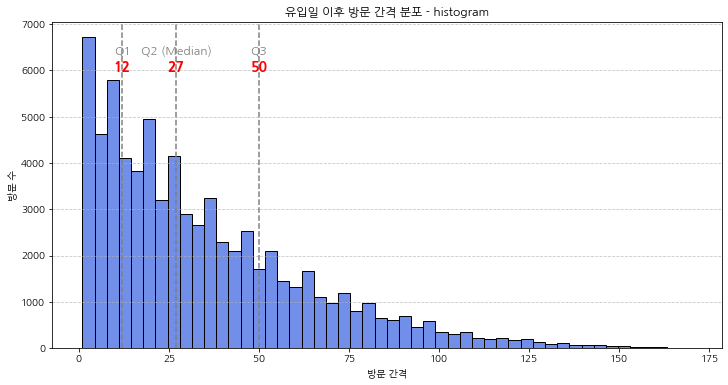

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')
%matplotlib inline

plt.figure(figsize=(12,6), facecolor='white')
sns.histplot(df_visit_interval['day_diff'], bins=50, color='royalblue')

# 사분위수
for q, label in zip([q1, q2, q3], ["Q1", "Q2 (Median)", "Q3"]):
    plt.axvline(q, color="gray", linestyle="dashed", linewidth=1.5)
    plt.text(q, plt.ylim()[1] * 0.9, label, color="gray", ha="center", fontsize=12)
    plt.text(q, plt.ylim()[1] * 0.85, q, color="red", ha="center", fontsize=14, fontweight="bold")


plt.xlabel("방문 간격")
plt.ylabel("방문 수")
plt.title("유입일 이후 방문 간격 분포 - histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 차트 출력
plt.show()

#### 주차별 리텐션
유입일 이후 주 단위로 봤을 때 얼마나 꾸준히 방문하는가?

In [68]:
sql = f"""
/* weekly range retention */

-- 2) 사용자별 첫방문일 기준 주 차이 계산
WITH week_diff_per_user AS (
  SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff
  FROM (
    -- 1) 사용자별 첫방문일, 방문일 리스트 추출
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_week) OVER(PARTITION BY user_pseudo_id) AS first_week,
      event_week
    FROM advanced.app_logs_cleaned_target
  )
)
, week_retain AS (
  -- 3) 주 차이별 이용자수 계산
  SELECT
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_user
  FROM week_diff_per_user
  GROUP BY week_diff
)

-- 5) 주 차이별 리텐션 비율 계산
, first_week_retain AS (
  SELECT
    COUNT(DISTINCT user_pseudo_id) AS first_week_retain_user
  FROM week_diff_per_user
  WHERE 1=1
  AND week_diff=0
)

SELECT
  week_.week_diff,
  week_.retain_user,
  first_week_.first_week_retain_user,
  ROUND(SAFE_DIVIDE(week_.retain_user, first_week_.first_week_retain_user)*100, 3) AS retention_ratio
FROM week_retain AS week_
CROSS JOIN first_week_retain AS first_week_
ORDER BY week_.week_diff ASC
"""

query_job = client.query(sql)
df_weekly_retention = query_job.to_dataframe()
df_weekly_retention.head()

,week_diff,retain_user,first_week_retain_user,retention_ratio
0,0,49678,49678,100.000
1,1,4375,49678,8.807
2,2,4599,49678,9.258
3,3,4673,49678,9.407
4,4,4545,49678,9.149


In [69]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_weekly_retention['week_diff'],
                         y=df_weekly_retention['retention_ratio'],
))

fig.update_layout(title_text="주차별 리텐션")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

### 사용 시간, 요일
#### 사용 시간대 분포

In [70]:
sql = f"""
-- 전체 유저 기준 주로 어느 시간대에 접속했는가?
SELECT
  EXTRACT(HOUR FROM event_time) AS event_hour,
  COUNT(DISTINCT user_pseudo_id) AS user_cnt
FROM advanced.app_logs_cleaned_target
GROUP BY event_hour
ORDER BY event_hour;
"""

query_job = client.query(sql)
df_visithour = query_job.to_dataframe()
df_visithour.head()

,event_hour,user_cnt
0,0,1069
1,1,1065
2,2,1066
3,3,1074
4,4,1058


In [71]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visithour['event_hour'],
                         y=df_visithour['user_cnt'],
))

fig.update_layout(title_text="시간대별 사용자 수 분포")
fig.update_xaxes(title_text='시간 (hour)')
fig.update_yaxes(title_text='사용자 수')

fig.show()

#### 사용 요일 + 시간대 분포

In [72]:
sql = f"""
-- 전체 유저 기준 주로 어느 요일+시간에 접속했는가?
SELECT DISTINCT
  FORMAT_DATETIME("%a %Hh", event_datetime) AS event_dow_hour,  -- 요일 + 시간 출력
  RANK() OVER (ORDER BY event_dow, event_hour) AS order_num,
  COUNT(DISTINCT user_pseudo_id) OVER (PARTITION BY event_dow, event_hour) AS user_cnt
FROM (
  SELECT
    event_datetime,
    event_dow,
    EXTRACT(HOUR FROM event_datetime) AS event_hour,
    user_pseudo_id
  FROM advanced.app_logs_cleaned_target
)
ORDER BY order_num
"""

query_job = client.query(sql)
df_visitdowhour = query_job.to_dataframe()
df_visitdowhour.head()

,event_dow_hour,order_num,user_cnt
0,Mon 00h,1,108
1,Mon 01h,749,110
2,Mon 02h,1409,109
3,Mon 03h,2118,106
4,Mon 04h,2786,108


In [73]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visitdowhour['event_dow_hour'],
                         y=df_visitdowhour['user_cnt'],
))

fig.update_layout(title_text="요일+시간대별 사용자 수 분포")
fig.update_xaxes(title_text="요일 + 시간")
fig.update_yaxes(title_text='사용자 수')

fig.show()

### 세션, 스크린뷰, 체류시간
#### 일별 유저당 평균 세션 수

In [74]:
sql = f"""
  -- 하루에 사용자들이 평균적으로 몇 번 방문하는가?
  -- 일별 유저당 평균 세션 수
  SELECT
    event_date,
    ROUND(AVG(session_cnt), 2) AS avg_sessions_per_user
  FROM (
    -- 일별 유저별 세션 수
    SELECT
      event_date,
      user_pseudo_id,
      COUNT(DISTINCT session_id) AS session_cnt,
    FROM `advanced.app_logs_cleaned_target`
    GROUP BY event_date, user_pseudo_id
  )
  GROUP BY event_date
  ORDER BY event_date
"""

query_job = client.query(sql)
df_sess_per_day_user = query_job.to_dataframe()
df_sess_per_day_user.head()

,event_date,avg_sessions_per_user
0,2022-08-01,1.0
1,2022-08-02,1.0
2,2022-08-03,1.0
3,2022-08-04,1.0
4,2022-08-05,1.0


In [75]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sess_per_day_user['event_date'],
                         y=df_sess_per_day_user['avg_sessions_per_user'],
))

fig.update_layout(title_text="일별 유저당 평균 세션 수 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='세션 수')

fig.show()

#### 일별 세션당 평균 스크린뷰

In [76]:
sql = f"""
-- 하루에 한 번 방문할 때 몇 개의 화면을 보는가?
-- 일별 세션당 평균 스크린뷰, 유니크뷰
SELECT
  event_date,
  ROUND(AVG(screen_view_cnt), 2) AS avg_screen_view_per_sess,
  ROUND(AVG(unique_view_cnt), 2) AS avg_unique_view_per_sess,
FROM (
  -- 일별 세션별 스크린뷰, 유니크뷰
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    COUNT(*) AS screen_view_cnt,
    COUNT(DISTINCT firebase_screen) AS unique_view_cnt,
  FROM `advanced.app_logs_cleaned_target`
  WHERE event_name='screen_view'
  GROUP BY event_date, user_pseudo_id, session_id
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_screenview_per_sess = query_job.to_dataframe()
df_screenview_per_sess.head()

,event_date,avg_screen_view_per_sess,avg_unique_view_per_sess
0,2022-08-01,3.06,3.05
1,2022-08-02,3.46,3.43
2,2022-08-03,3.27,3.25
3,2022-08-04,3.30,3.30
4,2022-08-05,3.18,3.16


In [78]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_screen_view_per_sess'],
                         name="screen view"
))

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_unique_view_per_sess'],
                         name="unique view"
))

fig.update_layout(title_text="일별 세션당 평균 스크린뷰 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='스크린뷰')

fig.show()

#### 일별 세션당 화면당 평균 체류시간

In [79]:
sql = f"""
-- 하루에 한 번 방문할 때 화면당 얼마나 머무르는가?
-- 일별 세션당 화면당 평균 체류시간 (firebase_screen별 체류시간)
SELECT
  event_date,
  ROUND(AVG(duration_time),2) AS avg_duration_time_per_screen,
FROM (
  -- 일별 세션당 화면당 체류시간
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    firebase_screen,
    DATETIME_DIFF(MAX(event_datetime), MIN(event_datetime), SECOND) AS duration_time,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date, user_pseudo_id, session_id, firebase_screen
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_duration_per_screen = query_job.to_dataframe()
df_duration_per_screen.head()

,event_date,avg_duration_time_per_screen
0,2022-08-01,10.99
1,2022-08-02,12.11
2,2022-08-03,11.63
3,2022-08-04,11.10
4,2022-08-05,10.80


In [80]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_duration_per_screen['event_date'],
                         y=df_duration_per_screen['avg_duration_time_per_screen'],
))

fig.update_layout(title_text="일별 세션당 화면당 평균 체류시간")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='체류시간 (초)')

fig.show()

### 주문
#### 일별 주문수 추이

In [81]:
sql = f"""
-- 일일 주문한 유저 수
SELECT
  event_date,
  COUNT(DISTINCT user_id) AS order_users_cnt
FROM advanced.app_logs_cleaned_target
WHERE event_name = 'click_payment'
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_order_user = query_job.to_dataframe()
df_order_user.head()

,event_date,order_users_cnt
0,2022-08-01,12
1,2022-08-02,21
2,2022-08-03,24
3,2022-08-04,12
4,2022-08-05,10


In [82]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_order_user['event_date'],
                         y=df_order_user['order_users_cnt'],
))

fig.update_layout(title_text="일별 주문 유저 수 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문한 사람 수')

fig.show()

#### DAU 대비 주문 유저 수 추이

In [83]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
  ORDER BY event_date
)

-- DAU와 일간 주문 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM dau_list d
INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
df_order_ratio = query_job.to_dataframe()
df_order_ratio.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,154,12,7.792
1,2022-08-02,157,21,13.376
2,2022-08-03,174,24,13.793
3,2022-08-04,162,12,7.407
4,2022-08-05,170,10,5.882


In [95]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['dau'],
                         name="DAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(title_text="DAU 대비 주문 유저 수 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

#### WAU 대비 주문 유저 수 추이

In [97]:
sql = f"""
WITH wau_list AS (
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
)
, order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    event_week,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_week
)

-- WAU와 주간 주문 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  w.event_week,
  w.wau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM wau_list w
INNER JOIN order_cnt_list_w o ON w.event_week = o.event_week
ORDER BY w.event_week ASC

"""

query_job = client.query(sql)
df_order_ratio_w = query_job.to_dataframe()
df_order_ratio_w.head()

,event_week,wau,order_users_cnt,order_ratio
0,2022-08-01,1181,120,10.161
1,2022-08-08,1367,105,7.681
2,2022-08-15,1985,255,12.846
3,2022-08-22,2191,225,10.269
4,2022-08-29,2612,267,10.222


In [99]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio_w['event_week'],
                         y=df_order_ratio_w['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio_w['event_week'],
                         y=df_order_ratio_w['wau'],
                         name="WAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(title_text="WAU 대비 주문 유저 수 추이")
fig.update_xaxes(title_text="주차")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()